This notebook contains:
1. Fixations count and fixations duration analysis for different categories;
2. Cumulative distribution function plots;
3. Correlational analysis.

### 0. Import statements & helper functions ###

In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [ ]:
## function_1 for leaving only experiment-relevant data

def filter_by_intervals(df, intervals, timestamp_col='timestamp [ns]'):
    """
    Filters a DataFrame to include only rows where the timestamp falls within any given intervals.

    Parameters:
        df: The DataFrame to filter.
        intervals (list of tuple): List of (start_time, end_time) pairs.
        timestamp_col (str): Name of the timestamp column.

    Returns:
        pd.DataFrame: Filtered DataFrame with rows in any of the intervals.
    """
    filter = pd.Series(False, index=df.index)  # start with all False

    for start, end in intervals:
        filter |= (df[timestamp_col] >= start) & (df[timestamp_col] <= end)

    return df[filter]


## function_2 to compute descriptive metrics of duration durations of each type

def compute_fixation_durations(fixations_df, fixation_type):
    """
    Compute average, min, and max duration for a given fixation type.
    """
    type_fixations = fixations_df[fixations_df['type'] == fixation_type]
    return type_fixations['duration [ms]'].agg(['mean', 'min', 'max', 'sum', 'median'])

## function_3 to calculate Median absolute deviation for durations
def median_abs_deviation(series):
    median = series.median()
    return (series - median).abs().median()

### 1. Main part ###

In [18]:
# Base path where all participant folders are located
base_path = "/Users/alina/Downloads/Thesis/raw/"

fixation_analysis = []
all_durations = []
participant_cdf_data = defaultdict(lambda: defaultdict(list))

# loading files for each recording based on how they are organised on my computer
for participant_folder in os.listdir(base_path):
    if participant_folder.startswith("Participant"):
        participant_number = participant_folder.split()[-1]
        participant_id = f"P{participant_number}"
        folder_path = os.path.join(base_path, participant_folder)

        for recording_folder in os.listdir(folder_path):
            if recording_folder.startswith(f"P{participant_number}_"):
                recording_number = recording_folder.split('_')[-1]
                recording_path = os.path.join(folder_path, recording_folder)

                try:
                    files = {
                        "fixations_on_everything": os.path.join(recording_path, f"fixations_on_everything_{participant_number}_{recording_number}.csv"),
                        "world_timestamps": os.path.join(recording_path, "world_timestamps.csv"),
                        "detections": os.path.join(recording_path, f"detections_{participant_number}_{recording_number}.csv"),
                        "face_detections": os.path.join(recording_path, "face_detections.csv"),
                        "events": os.path.join(recording_path, f"events.csv")
                    }
                    data = {name: pd.read_csv(file) for name, file in files.items()}

                    ### filtering all necessery files

                    # using events file to filter the data to only experiment-relevant
                    events_df = data["events"].sort_values("timestamp [ns]")
                    A_events, B_events, C_events, D_events = (events_df[events_df["name"] == event] for event in ['A', 'B', 'C', 'D'])
                    intervals = [
                        (A_events["timestamp [ns]"].max(), B_events["timestamp [ns]"].min()),
                        (B_events["timestamp [ns]"].max(), C_events["timestamp [ns]"].min()),
                        (C_events["timestamp [ns]"].max(), D_events["timestamp [ns]"].min())
                    ]

                    face_detections_df = filter_by_intervals(data["face_detections"], intervals)

                    video_df = pd.DataFrame({
                        "Frame": np.arange(len(data["world_timestamps"])),
                        "timestamp [ns]": data["world_timestamps"]['timestamp [ns]'],
                    })
                    filtered_frames = video_df['Frame']
                    detections_df = data["detections"][data["detections"]['Frame'].isin(filtered_frames)]

                    categorised_fixations_df = filter_by_intervals(data["fixations_on_everything"], intervals)

                    fixation_types = ['face', 'body', 'background']

                    # Collect individual fixation durations by participant and type
                    for fixation_type in fixation_types:
                        durations = categorised_fixations_df[categorised_fixations_df['type'] == fixation_type]['duration [ms]']
                        for duration in durations:
                            all_durations.append({
                                                'Participant': participant_id,
                                                'Fixation Type': fixation_type,
                                                'Duration': duration
                                                  })
                    # Create DataFrame with all durations for all recordings
                    durations_df = pd.DataFrame(all_durations)

                    ### steps to plot CDF for each articipant and fixation type later

                    # normalising time for better generazability
                    min_ts = categorised_fixations_df['timestamp [ns]'].min()
                    max_ts = categorised_fixations_df['timestamp [ns]'].max()
                    categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)

                    if participant_id not in participant_cdf_data:
                        participant_cdf_data[participant_id] = {ft: [] for ft in ['face', 'body', 'background']}

                    # grouping for fixation types
                    
                    for fixation_type, group in categorised_fixations_df.groupby('type'):
                        group = group.sort_values(by='timestamp [ns]')
                        group['cumulative_count'] = range(1, len(group) + 1)
                        group['cumulative_probability'] = group['cumulative_count'] / len(group)
                        
                        # grouping for participant
                        participant_cdf_data[participant_id][fixation_type].append(
                            group[['normalised_time', 'cumulative_probability']].reset_index(drop=True)
                        )


                    ### making a df with all relevant info for each recording for further analysis
                    fixation_counts = {f"{ft} fixations": len(categorised_fixations_df[categorised_fixations_df['type'] == ft]) for ft in fixation_types}
                    total_fixations = sum(fixation_counts.values())
                    fixation_percentages = {f"{ft} fixation %": (count / total_fixations) * 100 for ft, count in fixation_counts.items()}
                    duration_stats = {ft: compute_fixation_durations(categorised_fixations_df, ft) for ft in fixation_types}

                    fixation_analysis.append({
                        "Participant": participant_number,
                        "Recording": recording_number,
                        **fixation_counts,
                        "Total fixations": total_fixations,
                        **{f"{ft} {stat} duration (ms)": duration_stats[ft][stat] for ft in fixation_types for stat in ['mean', 'min', 'max', 'sum', 'median']},
                        "Face detections": len(face_detections_df),
                        "Body detections": len(detections_df),
                    })

                # error if some files weren't found/loaded
                except Exception as e:
                    print(f"❌ Error processing P{participant_number}_{recording_number}: {e}")

fixation_analysis_df = pd.DataFrame(fixation_analysis)

/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_48261/2047174805.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_48261/2047174805.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)


❌ Error processing P14_2: [Errno 2] No such file or directory: '/Users/alina/Downloads/Thesis/raw/Participant 14/P14_2/fixations_on_everything_14_2.csv'
❌ Error processing P14_1: [Errno 2] No such file or directory: '/Users/alina/Downloads/Thesis/raw/Participant 14/P14_1/fixations_on_everything_14_1.csv'


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_48261/2047174805.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_48261/2047174805.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)
/var/folders/r

In [19]:
save_path = os.path.join(base_path, 'Fixations_stats_all_recordings.csv')
fixation_analysis_df.to_csv(save_path, index=False) 

fixation_analysis_df

,Participant,Recording,face fixations,body fixations,background fixations,Total fixations,face mean duration (ms),face min duration (ms),face max duration (ms),face sum duration (ms),...,body max duration (ms),body sum duration (ms),body median duration (ms),background mean duration (ms),background min duration (ms),background max duration (ms),background sum duration (ms),background median duration (ms),Face detections,Body detections
0,09,2,140,2223,3185,5548,321.044071,80.125,2061.873,44946.170,...,2102.0,700717.0,245.0,319.490403,70.122,6756.253,1017576.933,235.247,140171,763126
1,09,1,226,2084,3854,6164,365.980889,85.125,1656.501,82711.681,...,5575.0,613120.0,225.0,304.503821,70.000,3173.002,1173557.725,230.237,141249,821406
2,12,1,139,1542,4283,5964,313.736439,75.122,2642.380,43609.365,...,2382.0,386818.0,200.0,267.564640,65.125,6586.134,1145979.352,205.124,83840,630660
3,12,2,47,1349,3731,5127,236.511234,80.016,610.504,11116.028,...,1872.0,324124.0,190.0,262.163733,65.000,8122.628,978132.887,195.250,86331,651126
4,15,1,77,1141,4529,5747,251.079545,70.125,845.757,19333.125,...,2097.0,340089.0,235.0,277.848956,70.000,6050.609,1258377.923,220.130,83200,612810
5,15,2,88,1469,3609,5166,330.988284,75.125,3658.495,29126.969,...,3253.0,480478.0,245.0,316.597190,70.000,3343.122,1142599.257,245.250,94699,623173
6,10,2,3,755,3927,4685,403.670000,200.125,720.626,1211.010,...,12296.0,302333.0,275.0,388.032550,70.000,17351.132,1523803.825,250.250,89661,666349
7,10,1,12,850,3067,3929,341.562917,105.000,985.876,4098.755,...,13628.0,400290.0,295.0,481.742538,70.000,12086.256,1477504.365,280.251,108195,765425
8,16,1,75,917,4281,5273,350.999880,75.000,7106.628,26324.991,...,3108.0,281285.0,260.0,297.384617,65.000,2277.131,1273103.547,255.250,88015,618793
9,16,2,35,797,4109,4941,245.786857,105.000,520.512,8602.540,...,3073.0,262143.0,270.0,318.378911,70.000,5610.249,1308218.945,265.247,93852,611668


In [5]:
categorised_fixations_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6851 entries, 465 to 7327
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp [ns]   6851 non-null   int64  
 1   type             6851 non-null   object 
 2   fixation id      6851 non-null   int64  
 3   duration [ms]    6851 non-null   float64
 4   normalised_time  6851 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 321.1+ KB


### 2. Plots ###

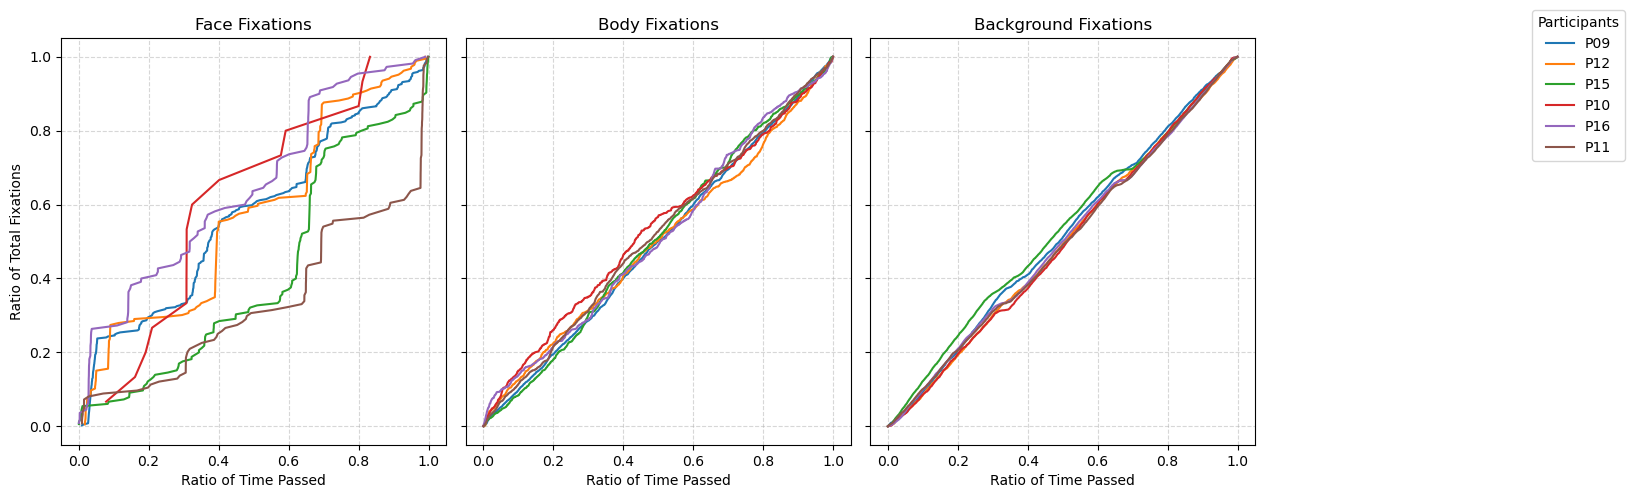

In [ ]:
fixation_cols = ['face', 'body', 'background']
duration_metrics = ['mean', 'min', 'max', 'sum', 'median']

agg_dict = {
    **{f"{ft} fixations": "sum" for ft in fixation_cols},
    "Total fixations": "sum",
    "Face detections": "sum",
    "Body detections": "sum",
    **{
        f"{ft} {stat} duration (ms)": "mean"  # or "sum" or another stat, depending on your goal
        for ft in fixation_cols
        for stat in duration_metrics
    }
}

participant_fixations_summary = fixation_analysis_df.groupby("Participant").agg(agg_dict).reset_index()

# Combine and compute per-participant merged CDFs
merged_participant_cdf = defaultdict(dict)

# Combine and compute per-participant merged CDFs
merged_participant_cdf = defaultdict(dict)

for participant_id, fixation_types in participant_cdf_data.items():
    for fixation_type, dfs in fixation_types.items():
        combined_df = pd.concat(dfs, ignore_index=True).sort_values(by='normalised_time').reset_index(drop=True)
        combined_df['cumulative_count'] = range(1, len(combined_df) + 1)
        combined_df['cumulative_probability'] = combined_df['cumulative_count'] / len(combined_df)
        merged_participant_cdf[fixation_type][participant_id] = combined_df[['normalised_time', 'cumulative_probability']]

# Plot all fixation types side by side (horizontal subplots)
fixation_types = list(merged_participant_cdf.keys())

fig, axes = plt.subplots(1, len(fixation_types), figsize=(5 * len(fixation_types), 5), sharey=True)

# If only one fixation type, axes might not be an array
if len(fixation_types) == 1:
    axes = [axes]

for ax, fixation_type in zip(axes, fixation_types):
    participant_dfs = merged_participant_cdf[fixation_type]
    for participant_id, df in participant_dfs.items():
        ax.plot(df['normalised_time'], df['cumulative_probability'], label=f'{participant_id}')
    ax.set_title(f'{fixation_type.capitalize()} Fixations')
    ax.set_xlabel('Ratio of Time Passed')
    ax.grid(True, linestyle='--', alpha=0.5)

axes[0].set_ylabel('Ratio of Total Fixations')

# Create consolidated legend on the right outside the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Participants', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend on right
plt.show()


Total percentage of face fixations for all participant is 1.4733021184437294.
Total percentage of body fixations for all participant is 25.72788140375494.
Total percentage of background fixations for all participant is 72.79881647780134.


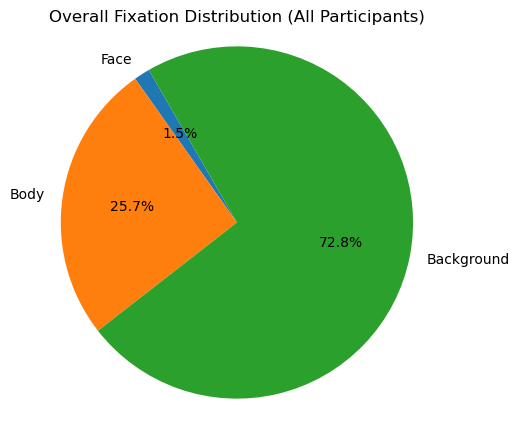

In [18]:
# Sum fixations across all participants
total_face = participant_fixations_summary['face fixations'].sum()
total_body = participant_fixations_summary['body fixations'].sum()
total_background = participant_fixations_summary['background fixations'].sum()

# Calculate total fixations
total_fixations = total_face + total_body + total_background

# Calculate percentages
face_pct = total_face * 100 / total_fixations
body_pct = total_body * 100 / total_fixations
background_pct = total_background * 100 / total_fixations

print(f"Total percentage of face fixations for all participant is {face_pct}.")
print(f"Total percentage of body fixations for all participant is {body_pct}.")
print(f"Total percentage of background fixations for all participant is {background_pct}.")

# Create the pie chart
labels = ['Face', 'Body', 'Background']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
percentages = [face_pct, body_pct, background_pct]

plt.figure(figsize=(5, 5))
plt.pie(percentages, labels=labels, colors=colors, autopct='%1.1f%%', startangle=120)
plt.title('Overall Fixation Distribution (All Participants)')
plt.axis('equal')
plt.show()


### Descriptive and Correlatiove stats ###

I first calculate the fixation count on each facial landmark and mean duration and then merge this dataframe with the face landmarks count dataframe. 

In [20]:
landmarks_df = pd.read_csv("/Users/alina/Downloads/Thesis/raw/face_landmarks_all_participants.csv")

# Ensure Participant columns are strings (also needed for replacement)
landmarks_df['Participant'] = landmarks_df['Participant'].astype(str)
fixation_analysis_df['Participant'] = fixation_analysis_df['Participant'].astype(str)

# Replace participant number '9' with '09'
landmarks_df['Participant'] = landmarks_df['Participant'].replace("9", "09")

# Ensure Recording columns are consistent dtype (choose strings here)
landmarks_df['Recording'] = landmarks_df['Recording'].astype(str)
fixation_analysis_df['Recording'] = fixation_analysis_df['Recording'].astype(str)

# Calculate mean duration for each AOI (Eyes, Nose, Mouth)
mean_duration_facial_landmarks = landmarks_df[landmarks_df['assigned_aoi'].isin(['left_eye', 'mouth', 'nose', 'right_eye'])] \
    .groupby(['Participant', 'Recording', 'assigned_aoi'])['duration (ms)'].mean().reset_index()

# mean durations per AOI per recording
mean_duration_facial_landmarks_df = mean_duration_facial_landmarks.pivot_table(
    index=['Participant', 'Recording'],
    columns='assigned_aoi',
    values='duration (ms)',
    aggfunc='mean'
).reset_index()

# Rename columns to include "mean duration" as the prefix, but exclude 'Participant' and 'Recording'
mean_duration_facial_landmarks_df = mean_duration_facial_landmarks_df.rename(columns=lambda x: f"mean duration {x}" if isinstance(x, str) and x not in ['Participant', 'Recording'] else x)

# Merge the mean durations into the combined_df
combined_df = fixation_analysis_df.merge(mean_duration_facial_landmarks_df, on=['Participant', 'Recording'], how='left')

# Create the AOI fixation counts table (pivot table)
aoi_counts = landmarks_df.pivot_table(
    index=['Participant', 'Recording'],
    columns='assigned_aoi',
    values='fixation_id',
    aggfunc='count',
    fill_value=0
).reset_index()

# Merge the AOI counts into the combined_df
combined_df = combined_df.merge(aoi_counts, on=['Participant', 'Recording'], how='left')


In [59]:
#combined_df.info()
#combined_df.describe().round(2)

#aoi_counts
#mean_duration_facial_landmarks_df

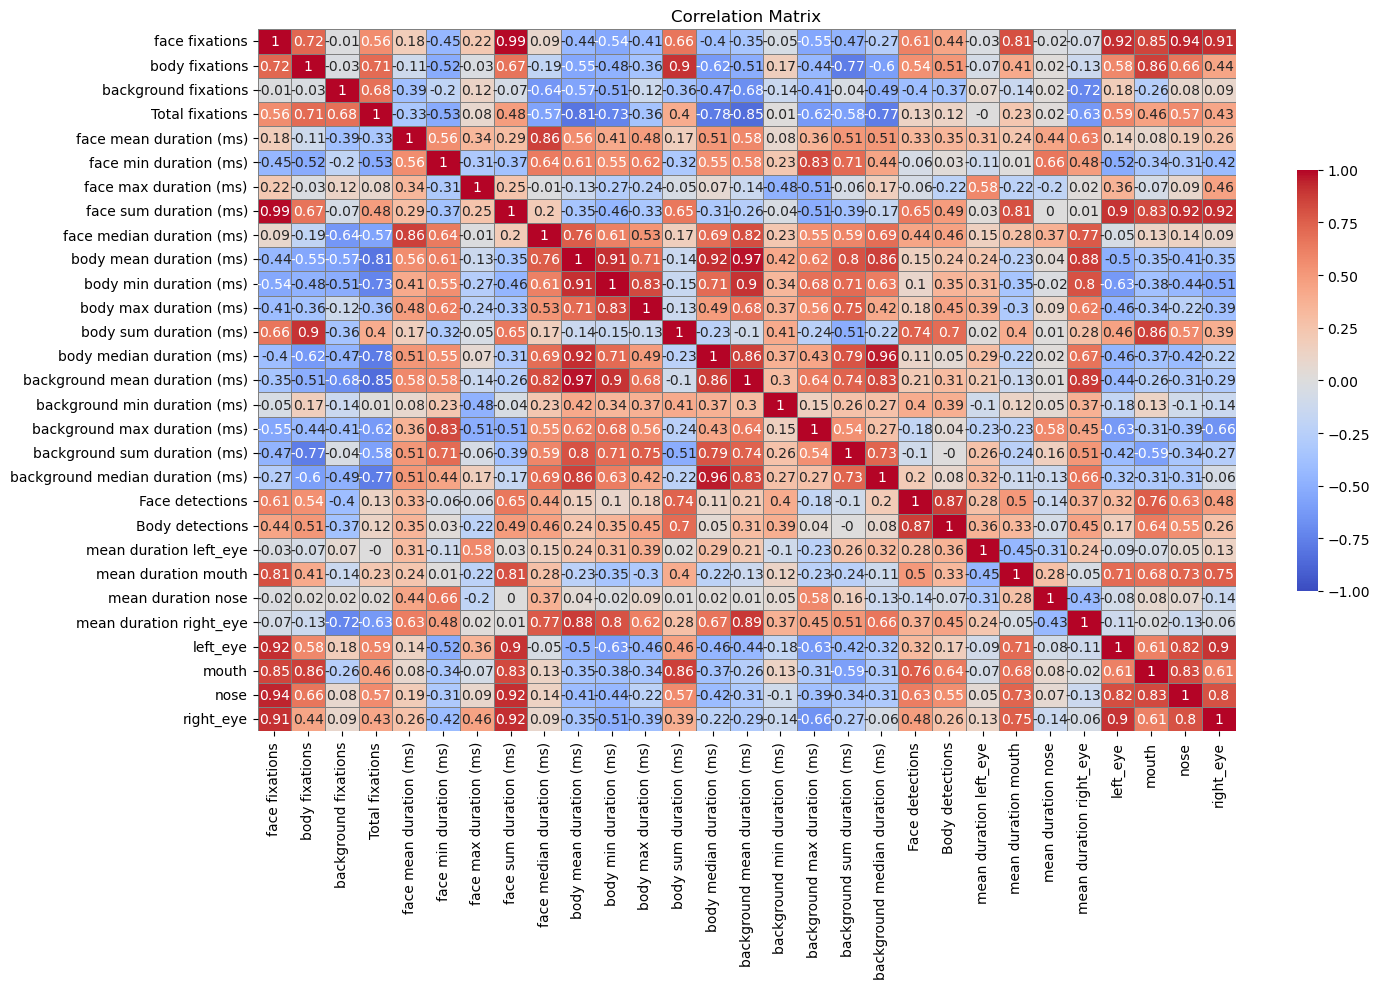

In [70]:
cols_to_exclude = ['Participant', 'Recording']

# Create a new DataFrame excluding those columns
df_corr = combined_df.drop(columns=cols_to_exclude)
corr_matrix = df_corr.corr().round(2)

plt.figure(figsize=(15, 10))

sns.heatmap(
    corr_matrix ,               
    annot=True,                  # Show correlation values in cells
    cmap='coolwarm',             # Color palette
    vmin=-1, vmax=1,             # Set color scale limits
    center=0,                    # Center the color map at 0 for balanced coloring
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.6}
)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

1. Duration metrics strongly correlate between different object categories.
2. Number of face and body detections moderately correlate with the number of face and body detections.
3. Face and body fixation number strongly correlate 
4. As well face and body detection number (which shows that the algorithms work).
5. Mouth correlates with body fixations
other add

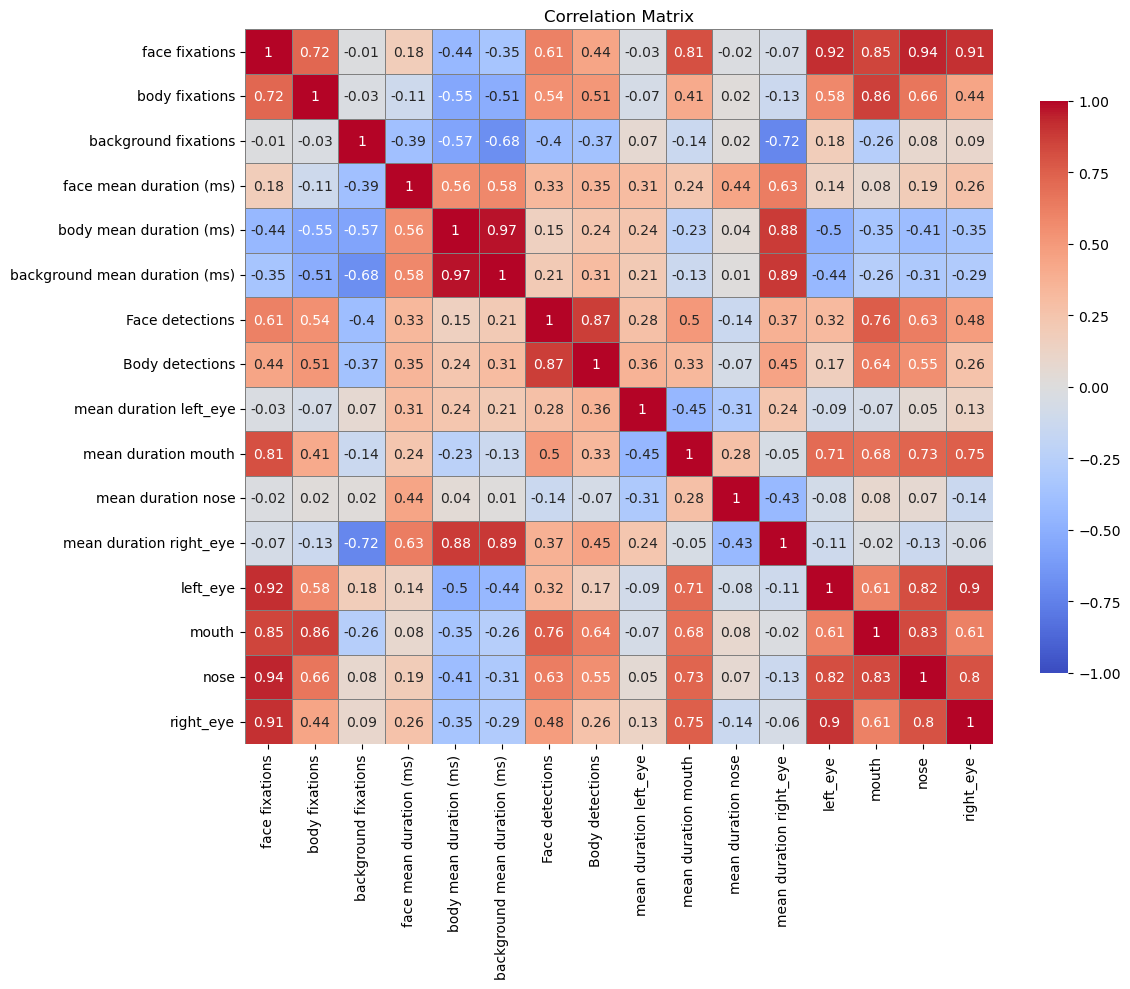

In [23]:
## only important variables matrix

cols_to_exclude = ['Participant', 'Recording', 'Total fixations', 
                   'body sum duration (ms)', 'face sum duration (ms)', 'background sum duration (ms)',
                   'body min duration (ms)', 'face min duration (ms)', 'background min duration (ms)',
                   'body max duration (ms)', 'face max duration (ms)', 'background max duration (ms)',
                   'body median duration (ms)', 'face median duration (ms)', 'background median duration (ms)' ]

# Create a new DataFrame excluding those columns
df_corr_small = combined_df.drop(columns=cols_to_exclude)
corr_matrix = df_corr_small.corr(method='pearson').round(2) #note correlation type

plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix ,               
    annot=True,                  # Show correlation values in cells
    cmap='coolwarm',             # Color palette
    vmin=-1, vmax=1,             # Set color scale limits
    center=0,                    # Center the color map at 0 for balanced coloring
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [ ]:
#participant_fixations_summary.info()
#participant_fixations_summary.describe().round()

In [ ]:
# I can also do the same correlations for the participants and not recordings

### PLots - fixation counts and durations ###

In [21]:
## fixation amounts mean and st deviation, correlations

describe_stats = participant_fixations_summary.describe()

### finding mean and st deviation of the fixation amount for each category between participants
mean_face_fix_amount = describe_stats.loc['mean', 'face fixations']
mean_body_fix_amount = describe_stats.loc['mean', 'body fixations']
mean_background_fix_amount = describe_stats.loc['mean', 'background fixations']

std_face = describe_stats.loc['std', 'face fixations']
std_body_fix_amount = describe_stats.loc['std', 'body fixations']
std_background_fix_amount = describe_stats.loc['std', 'background fixations']

summary_df = pd.DataFrame({
    'Category': ['Face', 'Body', 'Background'],
    'Mean': [mean_face_fix_amount, mean_body_fix_amount, mean_background_fix_amount],
    'Std Dev': [std_face, std_body_fix_amount, std_background_fix_amount],
})
summary_df = summary_df.round(2)
display(summary_df)

,Category,Mean,Std Dev
0,Face,161.00,116.58
1,Body,2811.50,1077.91
2,Background,7955.33,828.68


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_36513/767651322.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_36513/767651322.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


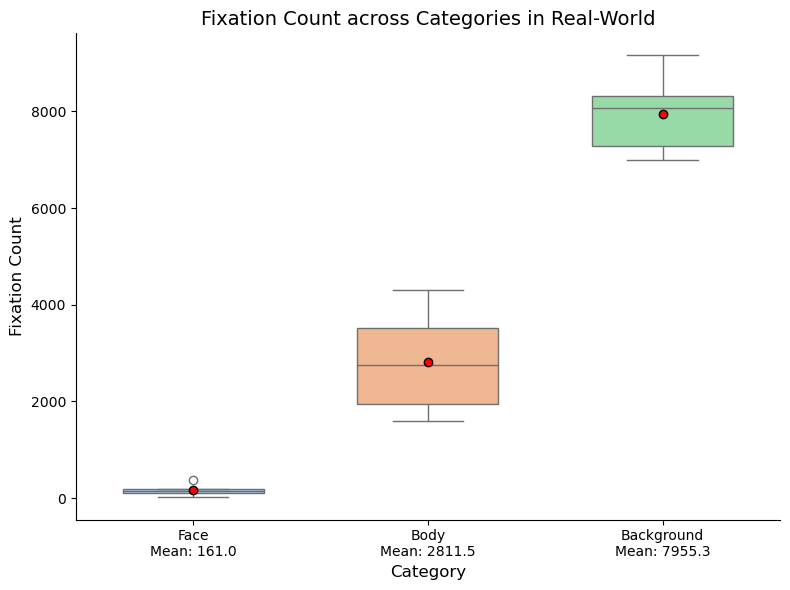

In [7]:
# Prepare data
fixation_cols = ['face fixations', 'body fixations', 'background fixations']
fixation_data = participant_fixations_summary[['Participant'] + fixation_cols]
fixation_melted = fixation_data.melt(id_vars='Participant',
                                     value_vars=fixation_cols,
                                     var_name='Category',
                                     value_name='Fixation Count')

fixation_melted['Category'] = fixation_melted['Category'].str.replace(' fixations', '').str.capitalize()

# Define explicit order of categories based on fixation_cols processing
category_order = [col.replace(' fixations', '').capitalize() for col in fixation_cols]

# Calculate means in the same order
group_means = fixation_melted.groupby('Category')['Fixation Count'].mean()
new_labels = [f"{cat}\nMean: {group_means[cat]:.1f}" for cat in category_order]

plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=fixation_melted,
    x='Category',
    y='Fixation Count',
    order=category_order,               # specify order explicitly here
    palette='pastel',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"},
    width=0.6
)

# Replace x-axis tick labels with category + mean, now matches order perfectly
ax.set_xticklabels(new_labels)

# Final formatting
ax.set_title("Fixation Count across Categories in Real-World", fontsize=14)
ax.set_ylabel("Fixation Count", fontsize=12)
ax.set_xlabel("Category", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

Fixation Type
background    75.12
body          80.00
face          90.12
Name: Duration, dtype: float64

/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_36513/2017757489.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_36513/2017757489.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=11)


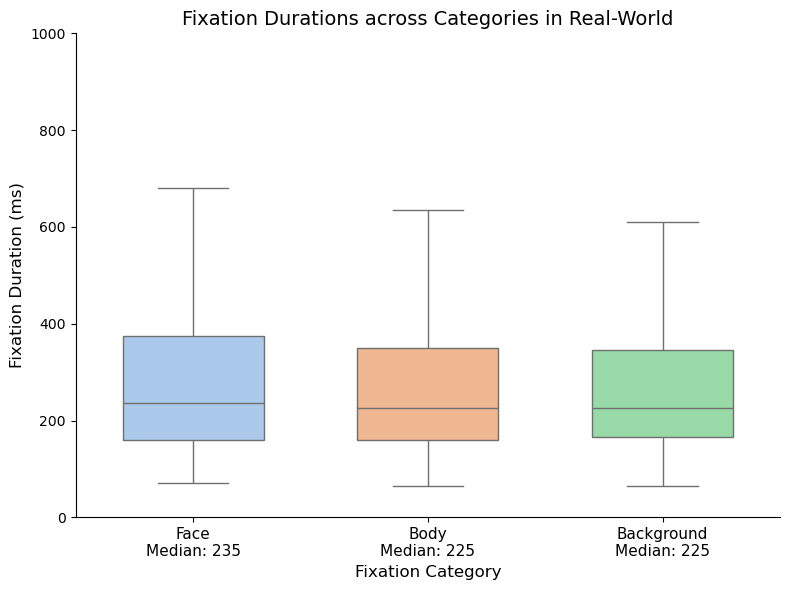

In [ ]:
group_mad = durations_df.groupby("Fixation Type")["Duration"].apply(median_abs_deviation).round(2)

display(group_mad)

category_order = ['face', 'body', 'background']  # Must match data

group_medians = durations_df.groupby("Fixation Type")["Duration"].median().round(2)

new_labels = [f"{cat.capitalize()}\nMedian: {group_medians[cat]:.0f}" for cat in category_order]

# if i want to add MAD to the label
#new_labels = [
    #f"{cat.capitalize()}\nMedian: {group_medians[cat]:.0f}\nMAD: {group_mad[cat]:.1f}"
    #for cat in category_order]

# Plot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=durations_df,
    x="Fixation Type",
    y="Duration",
    order=category_order,
    palette="pastel",
    #showmeans=True,
    showfliers=False,  # Hides grey outlier circles
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"},
    width=0.6
)

ax.set_xticklabels(new_labels, fontsize=11)
ax.set_title("Fixation Durations across Categories in Real-World", fontsize=14)
ax.set_ylabel("Fixation Duration (ms)", fontsize=12)
ax.set_ylim(0,1000)  # Set y-axis limits
ax.set_xlabel("Fixation Category", fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [32]:
fixation_analysis_df

,Participant,Recording,face fixations,body fixations,background fixations,Total fixations,face mean duration (ms),face min duration (ms),face max duration (ms),face sum duration (ms),...,body max duration (ms),body sum duration (ms),body median duration (ms),background mean duration (ms),background min duration (ms),background max duration (ms),background sum duration (ms),background median duration (ms),Face detections,Body detections
0,09,2,140,2223,3185,5548,321.044071,80.125,2061.873,44946.170,...,2102.0,700717.0,245.0,319.490403,70.122,6756.253,1017576.933,235.247,140171,763126
1,09,1,226,2084,3854,6164,365.980889,85.125,1656.501,82711.681,...,5575.0,613120.0,225.0,304.503821,70.000,3173.002,1173557.725,230.237,141249,821406
2,12,1,139,1542,4283,5964,313.736439,75.122,2642.380,43609.365,...,2382.0,386818.0,200.0,267.564640,65.125,6586.134,1145979.352,205.124,83840,630660
3,12,2,47,1349,3731,5127,236.511234,80.016,610.504,11116.028,...,1872.0,324124.0,190.0,262.163733,65.000,8122.628,978132.887,195.250,86331,651126
4,15,1,77,1141,4529,5747,251.079545,70.125,845.757,19333.125,...,2097.0,340089.0,235.0,277.848956,70.000,6050.609,1258377.923,220.130,83200,612810
5,15,2,88,1469,3609,5166,330.988284,75.125,3658.495,29126.969,...,3253.0,480478.0,245.0,316.597190,70.000,3343.122,1142599.257,245.250,94699,623173
6,10,2,3,755,3927,4685,403.670000,200.125,720.626,1211.010,...,12296.0,302333.0,275.0,388.032550,70.000,17351.132,1523803.825,250.250,89661,666349
7,10,1,12,850,3067,3929,341.562917,105.000,985.876,4098.755,...,13628.0,400290.0,295.0,481.742538,70.000,12086.256,1477504.365,280.251,108195,765425
8,16,1,75,917,4281,5273,350.999880,75.000,7106.628,26324.991,...,3108.0,281285.0,260.0,297.384617,65.000,2277.131,1273103.547,255.250,88015,618793
9,16,2,35,797,4109,4941,245.786857,105.000,520.512,8602.540,...,3073.0,262143.0,270.0,318.378911,70.000,5610.249,1308218.945,265.247,93852,611668


In [44]:
#### duration median + MAD

# Define function to compute true MAD
def median_absolute_deviation(series):
    median_val = np.median(series)
    mad = np.median(np.abs(series - median_val))
    return mad

# Columns to process
duration_cols = {
    'face': participant_fixations_summary['face median duration (ms)'],
    'body': participant_fixations_summary['body median duration (ms)'],
    'background': participant_fixations_summary['background median duration (ms)']
}

# Calculate median and MAD for each
duration_stats = {}
for label, series in duration_cols.items():
    duration_stats[label] = {
        'median (ms)': np.median(series),
        'MAD (ms)': median_absolute_deviation(series)
    }

# Convert to DataFrame for better display if needed
duration_df = pd.DataFrame(duration_stats).T.round(2)
display(duration_df)

,median (ms),MAD (ms)
face,220.22,18.78
body,237.50,30.00
background,232.72,30.03
